In [138]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [139]:
stock = yf.Ticker("AAPL") 
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False) 

In [140]:
df = data.reset_index()['Close']

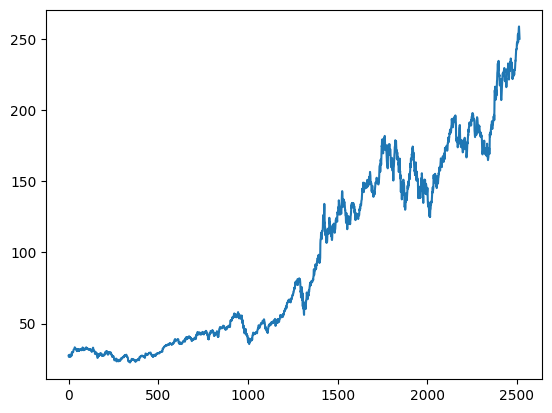

In [141]:
plt.plot(df)

In [142]:
df = df.rolling(window=5).mean().dropna()

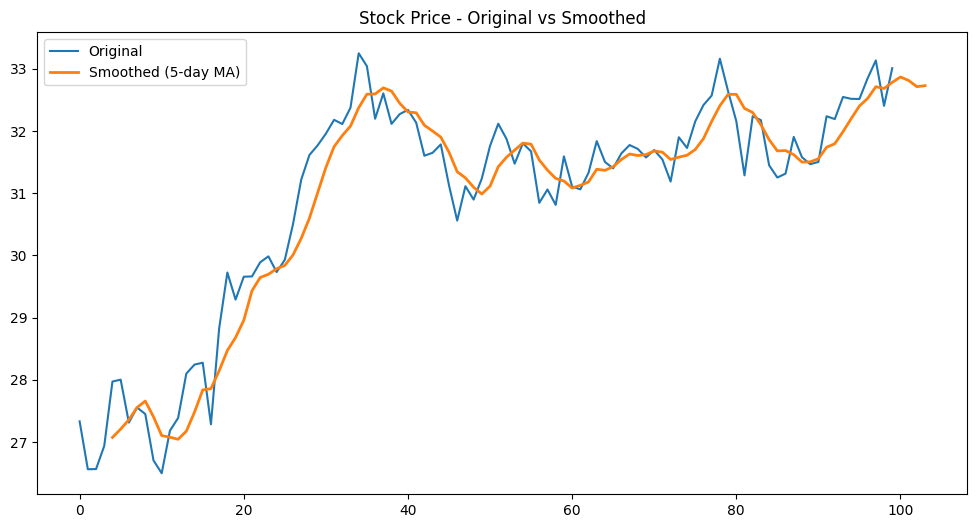

In [167]:
plt.figure(figsize=(12,6))
plt.plot(data.reset_index()['Close'][:100], label='Original')
plt.plot(df[:100], label='Smoothed (5-day MA)', linewidth=2)
plt.legend()
plt.title("Stock Price - Original vs Smoothed")
plt.show()

In [143]:
training_size = int(len(df)*0.8)
train_data = df[:training_size]
test_data = df[training_size:]

In [144]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_scaled = scaler.transform(np.array(test_data).reshape(-1, 1))

In [145]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [146]:
time_step = 100
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, ytest = create_dataset(test_data_scaled, time_step)

In [147]:
print(X_train.shape), print(y_train.shape)

(1909, 100)
(1909,)


(None, None)

In [148]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input
from tensorflow.keras.layers import Dropout

In [150]:
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [151]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam


model.compile(
    loss=Huber(delta=1.0),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mae']
)

In [152]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, ytest),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0859 - mae: 0.2919 - val_loss: 0.0621 - val_mae: 0.3422 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0060 - mae: 0.0878 - val_loss: 0.0085 - val_mae: 0.1141 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0029 - mae: 0.0564 - val_loss: 0.0035 - val_mae: 0.0680 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0026 - mae: 0.0465 - val_loss: 0.0017 - val_mae: 0.0469 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - mae: 0.0428 - val_loss: 0.0014 - val_mae: 0.0428 - learning_rate: 1.0000e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0019 - mae: 0.0405 - val_loss: 0.0012 - val_mae: 0.0399 - learning_rate: 1.0000e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0021 - mae: 0.0406 - val_loss: 0.0016 - val_mae: 0.0454 - lear

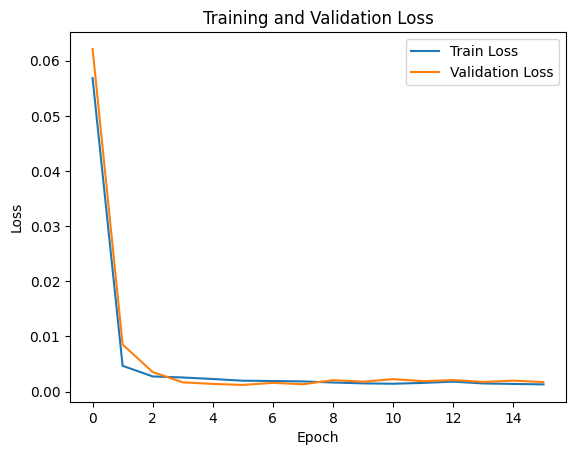

In [154]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [155]:
predictions = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [156]:
predictions = scaler.inverse_transform(predictions)

In [157]:
predictions

array([[173.58759],
       [173.91078],
       [174.20277],
       [174.48044],
       [174.76706],
       [175.09045],
       [175.4669 ],
       [175.88892],
       [176.342  ],
       [176.80994],
       [177.28114],
       [177.74467],
       [178.2136 ],
       [178.69339],
       [179.19804],
       [179.73209],
       [180.2916 ],
       [180.86092],
       [181.4276 ],
       [181.99464],
       [182.55064],
       [183.0879 ],
       [183.6143 ],
       [184.14458],
       [184.67459],
       [185.2264 ],
       [185.81125],
       [186.41806],
       [187.03795],
       [187.65738],
       [188.23654],
       [188.75687],
       [189.21838],
       [189.62141],
       [189.97346],
       [190.30591],
       [190.63913],
       [190.98659],
       [191.34502],
       [191.7077 ],
       [192.05869],
       [192.3941 ],
       [192.70798],
       [193.00021],
       [193.28888],
       [193.58311],
       [193.88165],
       [194.16614],
       [194.42596],
       [194.59698],


In [158]:
y_test_actual = scaler.inverse_transform(ytest.reshape(-1, 1))

In [159]:
y_test_actual

array([[173.15      ],
       [173.2039978 ],
       [173.82399902],
       [174.96199951],
       [176.61199951],
       [178.2039978 ],
       [179.03399963],
       [179.41600037],
       [179.53000183],
       [179.62600403],
       [179.62800598],
       [180.47000427],
       [181.29000244],
       [182.51600037],
       [183.6039978 ],
       [184.39599609],
       [184.63999634],
       [184.76999817],
       [185.37999878],
       [185.51399841],
       [185.58399963],
       [186.19400024],
       [187.2519989 ],
       [187.76999817],
       [189.22799988],
       [190.66600037],
       [191.32000122],
       [191.83200073],
       [192.05      ],
       [190.97799988],
       [190.1019989 ],
       [189.78999939],
       [189.53599854],
       [189.53800049],
       [190.61400146],
       [191.74400024],
       [192.81000061],
       [193.32800293],
       [193.57800293],
       [193.33000183],
       [193.30800171],
       [193.18800049],
       [193.20599976],
       [193

In [168]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")


RMSE: 7.648511443868138
MAE: 6.244713060554146
R² Score: 0.8916037108952212


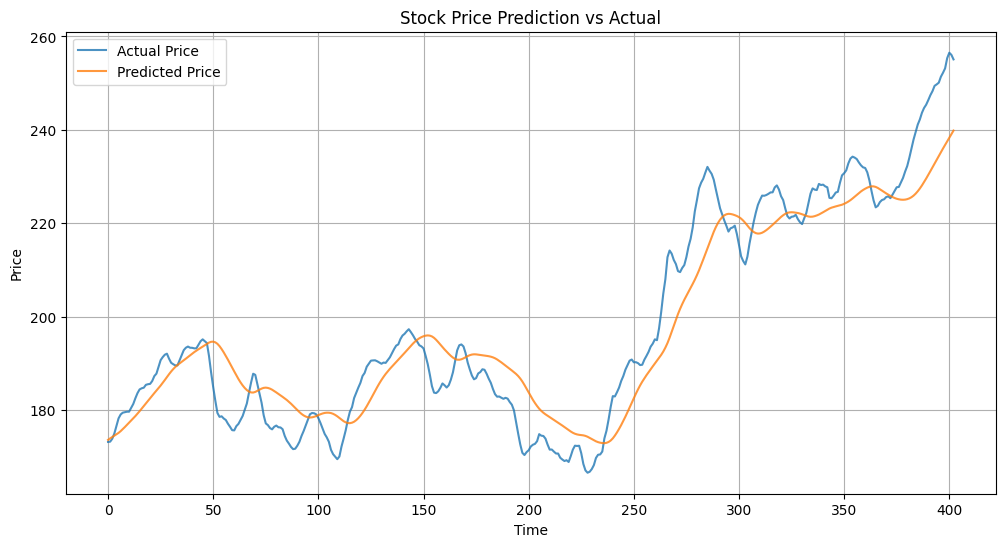

In [163]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', alpha=0.8)
plt.plot(predictions, label='Predicted Price', alpha=0.8)
plt.title('Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [163]:
# RMSE: 7.648511443868138
# MAE: 6.244713060554146
# R² Score: 0.8916037108952212